# MMLAB PLOTS MULTIMODAL PLOT BONANZA

We lean on several key measurments here to determine relationships between modalities.

* Coherence: Spectral coherence is a measure of the correlation between two signals in the frequency domain. 

* Cross-correlation: Cross-correlation is a measure of the similarity between two signals as a function of the time-lag applied to one of them.

* Mutual information: Mutual information quantifies the amount of information obtained about one random variable through another random variable. It is a measure of dependency, linear or non-linear.

* Phase locking value (PLV): PLV is a measure of the consistency of phase differences between two signals over time. It is often used in neuroscience to assess functional connectivity between brain regions.

* Phases: Phase analysis involves examining the phase relationships between signals, which can provide insights into synchronization and timing relationships.

* Correlation: Expression of linear relationships between two variables (this may be used if we want to look at whether more coupling between p1-p2 for modality X is predictive of more coupling in modality Y).

In [30]:
import pandas as pd
import numpy as np
import glob
import os
from scipy import signal
from scipy import stats
from sklearn.metrics import mutual_info_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches

# Your existing functions (keeping them as they are)
def compute_coherence(x, y, fs):
    f, Cxy = signal.coherence(x, y, fs)
    return f, Cxy

def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. Shift datax by N elements. """
    return datax.corr(datay.shift(lag))

def compute_mutual_information(x: np.ndarray, y: np.ndarray) -> float:
    """
    Compute mutual information between two time series using KDE.
    """
    # Clean data
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    if len(x) < 2 or len(y) < 2:
        return 0.0
    
    # Standardize the data
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)
    
    # Create KDE estimators
    kde_joint = stats.gaussian_kde(np.vstack([x, y]))
    kde_x = stats.gaussian_kde(x)
    kde_y = stats.gaussian_kde(y)
    
    # Sample points for numerical integration
    n_samples = 50
    x_range = np.linspace(min(x) - 1, max(x) + 1, n_samples)
    y_range = np.linspace(min(y) - 1, max(y) + 1, n_samples)
    X, Y = np.meshgrid(x_range, y_range)
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    # Evaluate densities
    joint_density = kde_joint(positions).reshape(X.shape)
    x_density = kde_x(X[0,:])
    y_density = kde_y(Y[:,0])
    X_density, Y_density = np.meshgrid(x_density, y_density)
    
    # Compute MI
    with np.errstate(divide='ignore', invalid='ignore'):
        mi_density = joint_density * np.log(joint_density / (X_density * Y_density))
    mi = np.nansum(mi_density) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    
    return max(0, mi)  # Ensure non-negative MI

def compute_coupling_statistics(name, motion_ts, sound_ts, time):
    """Your existing coupling statistics function"""
    # Ensure inputs are numpy arrays
    motion_ts = np.array(motion_ts)
    sound_ts = np.array(sound_ts)
    time = np.array(time)

    # Check if inputs are scalar (single values)
    if motion_ts.ndim == 0 or sound_ts.ndim == 0 or time.ndim == 0:
        return pd.DataFrame({
            'scene': [name],
            'lags': [np.nan],
            'crosscorr': [np.nan],
        }), np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # Check if inputs have the same length
    if len(motion_ts) != len(sound_ts) or len(motion_ts) != len(time):
        raise ValueError("motion_ts, sound_ts, and time must have the same length")

    # normalize and center the data
    motion_ts = (motion_ts - np.min(motion_ts)) / (np.max(motion_ts) - np.min(motion_ts))
    motion_ts = motion_ts - np.mean(motion_ts)
    sound_ts = (sound_ts - np.min(sound_ts)) / (np.max(sound_ts) - np.min(sound_ts))
    sound_ts = sound_ts - np.mean(sound_ts)

    # check if values are finite
    if not np.all(np.isfinite(motion_ts)) or not np.all(np.isfinite(sound_ts)):
        return pd.DataFrame({
            'scene': [name],
            'lags': [np.nan],
            'crosscorr': [np.nan],
        }), np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # Compute sampling frequency
    fs = 1/np.mean(np.diff(time))

    # compute the average mutual information
    mi = []
    lags = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]
    fs = 1/np.mean(np.diff(time))
    lags_samples = [int(lag * fs) for lag in lags]
    
    for lag in lags_samples:
        if lag < 0:
            motsub = motion_ts[:lag]
            soundsub = sound_ts[-lag:]
        elif lag > 0:
            motsub = motion_ts[lag:]
            soundsub = sound_ts[:-lag]
        else:
            motsub = motion_ts
            soundsub = sound_ts
            
        # Add smoothing to capture temporal dependencies
        window = int(0.1 * fs)  # 100ms window
        if window > 1:
            motsub = np.convolve(motsub, np.ones(window)/window, mode='valid')
            soundsub = np.convolve(soundsub, np.ones(window)/window, mode='valid')
        
        mi_value = compute_mutual_information(motsub, soundsub)
        mi.append(mi_value)
    
    max_mi = np.max(mi)
    optimal_lag = lags[np.argmax(mi)]
    
    #################################################### Coherence
    # Compute coherence
    f, Cxy = compute_coherence(motion_ts, sound_ts, fs)

    # keep all values lower than 10 Hz
    mask = f < 10
    Cxy = Cxy[mask]
    f = f[mask]

    # maximum coherence
    coherence = np.max(Cxy)

    # Frequency of max coherence
    f_max = f[np.argmax(Cxy)]
        
    #################################################### Cross-correlation
    lag_seconds = 0.3
    lag_points = int(lag_seconds * fs)

    # Create a range of lags to examine
    lags = np.arange(-lag_points, lag_points + 1)

    # calc cross-cor
    cc = [crosscorr(pd.Series(motion_ts), pd.Series(sound_ts), lag) for lag in lags]

    # Calculate cross-correlation
    crosscorrdf = pd.DataFrame({
        'scene': name,
        'lags': lags*(1/fs),
        'crosscorr': cc,
    })

    ########## Phase locking value
    # Compute analytic signal (using Hilbert transform)
    motion_analytic = signal.hilbert(motion_ts)
    sound_analytic = signal.hilbert(sound_ts)

    # Extract instantaneous phase
    motion_phase = np.angle(motion_analytic)
    sound_phase = np.angle(sound_analytic)

    # Compute phase difference
    phase_diff = motion_phase - sound_phase

    # compute the plv
    plv = np.abs(np.mean(np.exp(1j * phase_diff)))
    
    # make phase_diff a regular list not a numpy array
    try:
        motion_phase = motion_phase.tolist()[0] if hasattr(motion_phase, 'tolist') else motion_phase[0]
        phase_diff = phase_diff.tolist()[0] if hasattr(phase_diff, 'tolist') else phase_diff[0]
    except:
        motion_phase = np.mean(motion_phase)
        phase_diff = np.mean(phase_diff)

    return crosscorrdf, coherence, f_max, max_mi, phase_diff, plv, optimal_lag

def calculate_p1_p2_coupling_stats(merged_folder='../merged_filteredtimeseries/', output_file='p1_p2_coupling_statistics.csv'):
    """
    Loop through merged time series files and calculate coupling statistics between P1 and P2
    """
    
    # Find all merged CSV files
    csv_files = glob.glob(os.path.join(merged_folder, "*.csv"))
    print(f"Found {len(csv_files)} files to process")
    
    # Define P1-P2 variable pairs to analyze
    p1_modalities = ['Amplitude_Envelope_P1', 'Filtered_ECG_P1', 'Filtered_Respiration_P1', 'Filtered_EMG_Bicep_P1', 'Filtered_EMG_Tricep_P1', 'right_index_x_P1', 'right_index_y_P1', 'right_index_z_P1']
    p2_modalities = ['Amplitude_Envelope_P2', 'Filtered_ECG_P2', 'Filtered_Respiration_P2', 'Filtered_EMG_Bicep_P2', 'Filtered_EMG_Tricep_P2', 'right_index_x_P2', 'right_index_y_P2', 'right_index_z_P2']

    variable_pairs = []
    # Add same-participant, same-modality (if needed for matrix)
    for i in range(len(p1_modalities)):
        p1_var = p1_modalities[i]
        p2_var = p2_modalities[i] # Assumes corresponding P1/P2 vars are at same index
        if p1_var.replace('_P1', '') == p2_var.replace('_P2', ''): # Only if same modality
            variable_pairs.append((p1_var, p2_var))

    # Add ALL cross-participant pairs (same and cross-modality)
    for p1_var in p1_modalities:
        for p2_var in p2_modalities:
            if (p1_var.replace('_P1', '') == p2_var.replace('_P2', '')) and (p1_var.replace('_P1', '') == 'Amplitude_Envelope'):
                # This is the P1-P2 envelope, which is handled separately in plotting
                # You might want to exclude it here if you only want to compute it once for the scatter plots
                pass
            else:
                variable_pairs.append((p1_var, p2_var))
    
    # Initialize results list
    results = []
    
    # Loop through each file
    for file_path in csv_files:
        print(f"\nProcessing: {os.path.basename(file_path)}")
        
        try:
            # Load the data
            df = pd.read_csv(file_path)
            
            # Extract metadata from filename and dataframe
            filename = os.path.basename(file_path)
            
            # Try to extract condition information
                # if filename has NoVision or NoMovement, set to 'NoVision' or 'NoMovement'
            condition_vision = 'Vision' if 'NoVision' not in filename else 'NoVision'
            condition_movement = 'Movement' if 'NoMovement' not in filename else 'NoMovement'
            trial = df['Trial'].iloc[0] if 'Trial' in df.columns else 'Unknown'
            
            # Get time vector
            time = df['Time'].values
            
            # Check if we have enough data (at least 3 seconds)
            if time.max() - time.min() < 5.0:
                print(f"  Skipping {filename}: insufficient data duration ({time.max() - time.min():.2f}s)")
                continue
            
            # Set up sliding window analysis
            window_duration = 5.0  # seconds
            step_size = 1.0  # seconds
            n_windows = int((time.max() - time.min() - window_duration) / step_size) + 1
            
            print(f"  Analyzing {n_windows} windows of {window_duration}s each")
            
            # Loop through each variable pair
            for var1, var2 in variable_pairs:
                if var1 not in df.columns or var2 not in df.columns:
                    continue
                    
                print(f"    Processing {var1} vs {var2}")
                
                # Loop through sliding windows
                for window_idx in range(n_windows):
                    window_start = time.min() + window_idx * step_size
                    window_end = window_start + window_duration
                    
                    # Extract window data
                    window_mask = (time >= window_start) & (time <= window_end)
                    time_window = time[window_mask]
                    var1_window = df[var1].values[window_mask]
                    var2_window = df[var2].values[window_mask]
                    
                    # Skip if not enough data in window or too many NaNs
                    if len(time_window) < 100 or np.sum(~np.isnan(var1_window)) < 50 or np.sum(~np.isnan(var2_window)) < 50:
                        continue
                    
                    try:
                        # Calculate coupling statistics
                        crosscorrdf, coherence, f_max, max_mi, phase_diff, plv, optimal_lag = \
                            compute_coupling_statistics(filename, var1_window, var2_window, time_window)
                        
                        # Extract max cross-correlation
                        max_crosscorr = crosscorrdf['crosscorr'].abs().max() if not crosscorrdf.empty else np.nan
                        lag_at_max_crosscorr = crosscorrdf.loc[crosscorrdf['crosscorr'].abs().idxmax(), 'lags'] if not crosscorrdf.empty else np.nan
                        
                        # Store results
                        result = {
                            'filename': filename,
                            'condition_vision': condition_vision,
                            'condition_movement': condition_movement,
                            'trial': trial,
                            'window_idx': window_idx,
                            'window_start': window_start,
                            'window_end': window_end,
                            'var1': var1,
                            'var2': var2,
                            'variable_pair_type': classify_variable_pair(var1, var2),
                            'max_crosscorr': max_crosscorr,
                            'lag_at_max_crosscorr': lag_at_max_crosscorr,
                            'max_coherence': coherence,
                            'freq_at_max_coherence': f_max,
                            'max_mutual_info': max_mi,
                            'optimal_lag_mi': optimal_lag,
                            'phase_locking_value': plv,
                            'mean_phase_diff': phase_diff,
                            'n_samples': len(time_window),
                            'sampling_rate': 1/np.mean(np.diff(time_window))
                        }
                        
                        results.append(result)
                        
                    except Exception as e:
                        print(f"      Error in window {window_idx}: {e}")
                        continue
                        
        except Exception as e:
            print(f"  Error processing {filename}: {e}")
            continue
    
    # Convert to DataFrame
    if results:
        results_df = pd.DataFrame(results)
        
        # Save to CSV
        results_df.to_csv(output_file, index=False)
        print(f"\n✓ Saved {len(results_df)} coupling statistics to {output_file}")
        
        # Print summary statistics
        print(f"\nSummary:")
        print(f"  Files processed: {results_df['filename'].nunique()}")
        print(f"  Variable pairs analyzed: {results_df['variable_pair_type'].nunique()}")
        print(f"  Total windows analyzed: {len(results_df)}")
        print(f"  Conditions: {results_df['condition_vision'].unique()} x {results_df['condition_movement'].unique()}")
        
        return results_df
    else:
        print("No results generated - check your data files and variable names")
        return pd.DataFrame()

def classify_variable_pair(var1, var2):
    """
    Classify the type of variable pair for easier analysis
    """
    # Extract modality information
    modalities = []
    participants = []
    
    for var in [var1, var2]:
        if 'Amplitude_Envelope' in var:
            modalities.append('Audio')
        elif 'heart_rate' in var:
            modalities.append('ECG')
        elif 'Respiration' in var:
            modalities.append('Respiration')
        elif 'EMG' in var:
            modalities.append('EMG')
        elif 'right_index' in var:
            modalities.append('Motion')
        else:
            modalities.append('Other')
            
        if '_P1' in var:
            participants.append('P1')
        elif '_P2' in var:
            participants.append('P2')
        else:
            participants.append('Unknown')
    
    # Classify pair type
    if participants[0] == participants[1]:
        if participants[0] == 'P1':
            pair_type = 'Within_P1'
        else:
            pair_type = 'Within_P2'
    else:
        pair_type = 'Between_Participants'
    
    if modalities[0] == modalities[1]:
        modality_type = f"Same_{modalities[0]}"
    else:
        modality_type = f"Cross_{modalities[0]}_{modalities[1]}"
    
    return f"{pair_type}_{modality_type}"


def create_modality_network_plots(results_df, output_folder='coupling_plots/'):
    """
    Create network visualizations showing P1-P2 modality coupling
    Network 1: P1 and P2 modalities as separate nodes with directed edges
    Network 2: Envelope coupling vs all other P1-P2 coupling pairs
    """
    
    os.makedirs(output_folder, exist_ok=True)
    
    # Define consistent color scheme for conditions
    CONDITION_COLORS = {
        'NoVision x Movement': '#e41a1c',      # Red
        'NoVision x NoMovement': '#377eb8',    # Blue  
        'Vision x Movement': '#4daf4a',        # Green
        'Vision x NoMovement': '#984ea3'       # Purple
    }
    
    def get_modality_from_var(var_name):
        if 'Amplitude_Envelope' in var_name:
            return 'Audio'
        elif 'Filtered_ECG' in var_name:  # Added Filtered_ECG mapping
            return 'Heart Rate'
        elif 'Filtered_Respiration' in var_name:
            return 'Respiration'
        elif 'Filtered_EMG_Bicep' in var_name:
            return 'EMG Bicep'
        elif 'Filtered_EMG_Tricep' in var_name:
            return 'EMG Tricep'
        elif 'right_index_x' in var_name:
            return 'Motion X'
        elif 'right_index_y' in var_name:
            return 'Motion Y'
        elif 'right_index_z' in var_name:
            return 'Motion Z'
        else:
            return 'Unknown'
    
    # Get P1-P2 coupling data
    p1_p2_data = results_df[
        (results_df['var1'].str.contains('_P1')) &
        (results_df['var2'].str.contains('_P2'))
    ].copy()
    
    if len(p1_p2_data) == 0:
        print("No P1-P2 coupling data found!")
        return
    
    # Add modality information
    p1_p2_data['modality1'] = p1_p2_data['var1'].apply(get_modality_from_var)
    p1_p2_data['modality2'] = p1_p2_data['var2'].apply(get_modality_from_var)
    
    # Get conditions
    conditions = p1_p2_data.groupby(['condition_vision', 'condition_movement']).size().reset_index()[['condition_vision', 'condition_movement']]
    
    # ============================================
    # CALCULATE GLOBAL MIN/MAX VALUES FOR CONSISTENT SCALING
    # ============================================
    
    print("\n=== Calculating Global Min/Max for Consistent Scaling ===")
    
    # Collect ALL MI values across all conditions for Network 1
    all_mi_values_network1 = []
    
    for _, cond_row in conditions.iterrows():
        vision = cond_row['condition_vision']
        movement = cond_row['condition_movement']
        
        cond_data = p1_p2_data[
            (p1_p2_data['condition_vision'] == vision) & 
            (p1_p2_data['condition_movement'] == movement)
        ]
        
        if len(cond_data) > 0:
            valid_mi = cond_data['max_mutual_info'].dropna().values
            all_mi_values_network1.extend(valid_mi)
    
    global_mi_min = 0  # MI is always >= 0
    global_mi_max = np.percentile(all_mi_values_network1, 95) if len(all_mi_values_network1) > 0 else 2.0
    
    print(f"Global MI range for edges: {global_mi_min:.3f} - {global_mi_max:.3f}")
    
    # ============================================
    # NETWORK 1: P1-P2 MODALITY NETWORKS WITH JITTER PLOTS (GLOBAL SCALING)
    # ============================================
    
    print("\n=== Creating P1-P2 Modality Networks with Jitter Plots (Global Scaling) ===")
    
    for _, cond_row in conditions.iterrows():
        vision = cond_row['condition_vision']
        movement = cond_row['condition_movement']
        cond_name = f"{vision} x {movement}"
        
        print(f"  Creating network with jitter plot for: {cond_name}")
        
        # Get data for this condition
        cond_data = p1_p2_data[
            (p1_p2_data['condition_vision'] == vision) & 
            (p1_p2_data['condition_movement'] == movement)
        ]
        
        if len(cond_data) == 0:
            continue
        
        # Create subplot layout: network on left, jitter plot on right
        fig, (ax_net, ax_jitter) = plt.subplots(1, 2, figsize=(24, 12))
        
        # ============================================
        # LEFT PANEL: NETWORK PLOT
        # ============================================
        
        # Create directed graph
        G = nx.DiGraph()
        
        # Get unique modalities
        modalities = sorted(list(set(cond_data['modality1'].unique()) | 
                                set(cond_data['modality2'].unique())))
        modalities = [m for m in modalities if m != 'Unknown']
        
        # Add nodes for P1 and P2 versions of each modality
        for modality in modalities:
            G.add_node(f"{modality}_P1", participant='P1', modality=modality)
            G.add_node(f"{modality}_P2", participant='P2', modality=modality)
        
        # Add edges based on coupling strength
        edge_weights = []
        for _, row in cond_data.iterrows():
            p1_mod = row['modality1']
            p2_mod = row['modality2']
            mi_value = row['max_mutual_info']
            
            if not np.isnan(mi_value) and p1_mod != 'Unknown' and p2_mod != 'Unknown':
                G.add_edge(f"{p1_mod}_P1", f"{p2_mod}_P2", weight=mi_value)
                edge_weights.append(mi_value)
        
        if len(edge_weights) > 0:
            # Position nodes in two columns (P1 left, P2 right)
            pos = {}
            y_positions = np.linspace(1, 0, len(modalities))
            
            for i, modality in enumerate(modalities):
                pos[f"{modality}_P1"] = (0, y_positions[i])
                pos[f"{modality}_P2"] = (1, y_positions[i])
            
            # Node colors and sizes
            node_colors = []
            node_sizes = []
            for node in G.nodes():
                if '_P1' in node:
                    node_colors.append('lightblue')
                else:
                    node_colors.append('lightcoral')
                node_sizes.append(3000)
            
            # Edge colors and widths based on MI strength (GLOBAL MIN/MAX)
            edges = G.edges()
            edge_weights = [G[u][v]['weight'] for u, v in edges]
            
            # Calculate normalized values once for consistent scaling
            if len(edge_weights) > 0 and global_mi_max > global_mi_min:
                normalized_values = [(w - global_mi_min) / (global_mi_max - global_mi_min) for w in edge_weights]
                edge_widths = [1 + 8 * norm_val for norm_val in normalized_values]  # 1-9 width range
                edge_colors = [plt.cm.viridis(norm_val) for norm_val in normalized_values]
            else:
                edge_widths = [5] * len(edge_weights)  # Default width
                edge_colors = ['gray'] * len(edge_weights)
            
            # Draw network
            nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                                  ax=ax_net, alpha=0.8, edgecolors='black', linewidths=2)
            
            # Draw edges with varying thickness and color
            for i, (u, v) in enumerate(edges):
                if i < len(edge_widths):
                    x1, y1 = pos[u]
                    x2, y2 = pos[v]
                    
                    # Use pre-calculated color and width (both scaled identically)
                    arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                          connectionstyle="arc3,rad=0.1",
                                          arrowstyle='->', mutation_scale=20,
                                          linewidth=edge_widths[i],
                                          color=edge_colors[i],
                                          alpha=0.8)
                    ax_net.add_patch(arrow)
            
            # Add labels for nodes
            labels = {}
            for node in G.nodes():
                modality = node.replace('_P1', '').replace('_P2', '')
                participant = 'P1' if '_P1' in node else 'P2'
                labels[node] = f"{modality}\n({participant})"
            
            nx.draw_networkx_labels(G, pos, labels, font_size=12, font_weight='bold', ax=ax_net)
            
            # Add participant group labels
            ax_net.text(0, 1.1, 'P1 Modalities', ha='center', va='center', 
                       fontsize=18, fontweight='bold', 
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
            ax_net.text(1, 1.1, 'P2 Modalities', ha='center', va='center', 
                       fontsize=18, fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
            
            # Add colorbar with GLOBAL scale for edge weights
            sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                                      norm=plt.Normalize(vmin=global_mi_min, vmax=global_mi_max))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax_net, shrink=0.6, pad=0.1)
            cbar.set_label('Mutual Information (Global Scale)', fontsize=14, fontweight='bold')
            cbar.ax.tick_params(labelsize=12)
            
            ax_net.set_xlim(-0.3, 1.3)
            ax_net.set_ylim(-0.2, 1.3)
            ax_net.set_aspect('equal')
            ax_net.axis('off')
            ax_net.set_title(f'P1-P2 Modality Coupling Network\n{cond_name}', 
                            fontsize=20, fontweight='bold', pad=20)
        
        # ============================================
        # RIGHT PANEL: JITTER PLOT
        # ============================================
        
        # Categorize P1-P2 pairs
        envelope_data = []
        within_modality_data = []
        cross_modality_data = []
        
        for _, row in cond_data.iterrows():
            mod1 = row['modality1']
            mod2 = row['modality2']
            mi_val = row['max_mutual_info']
            
            if np.isnan(mi_val):
                continue
                
            # Categorize the pair
            if mod1 == 'Audio' and mod2 == 'Audio':
                envelope_data.append(mi_val)
            elif mod1 == mod2:  # Same modality (but not audio)
                within_modality_data.append(mi_val)
            else:  # Different modalities
                cross_modality_data.append(mi_val)
        
        # Create jitter plot
        categories = []
        values = []
        colors = []
        
        if len(envelope_data) > 0:
            categories.extend(['Envelope\nP1-P2'] * len(envelope_data))
            values.extend(envelope_data)
            colors.extend(['gold'] * len(envelope_data))
        
        if len(within_modality_data) > 0:
            categories.extend(['Within-Modality\nP1-P2'] * len(within_modality_data))
            values.extend(within_modality_data)
            colors.extend(['lightgreen'] * len(within_modality_data))
        
        if len(cross_modality_data) > 0:
            categories.extend(['Cross-Modality\nP1-P2'] * len(cross_modality_data))
            values.extend(cross_modality_data)
            colors.extend(['lightcoral'] * len(cross_modality_data))
        
        if len(values) > 0:
            # Convert to DataFrame for easier plotting
            jitter_df = pd.DataFrame({
                'category': categories,
                'mi_value': values,
                'color': colors
            })
            
            # Plot jitter plot
            category_names = jitter_df['category'].unique()
            for i, cat in enumerate(category_names):
                cat_data = jitter_df[jitter_df['category'] == cat]
                
                # Add jitter to x-axis
                x_jitter = np.random.normal(i, 0.1, len(cat_data))
                
                ax_jitter.scatter(x_jitter, cat_data['mi_value'], 
                                 c=cat_data['color'].iloc[0], s=60, alpha=0.7, 
                                 edgecolors='black', linewidth=0.5)
                
                # Add mean line
                mean_val = cat_data['mi_value'].mean()
                ax_jitter.plot([i-0.3, i+0.3], [mean_val, mean_val], 
                              'k-', linewidth=3, alpha=0.8)
            
            ax_jitter.set_xticks(range(len(category_names)))
            ax_jitter.set_xticklabels(category_names, fontsize=14, fontweight='bold')
            ax_jitter.set_ylabel('Mutual Information', fontsize=16, fontweight='bold')
            ax_jitter.set_title(f'MI Distribution by Coupling Type\n{cond_name}', 
                               fontsize=18, fontweight='bold')
            ax_jitter.grid(True, alpha=0.3)
            ax_jitter.tick_params(axis='both', which='major', labelsize=12)
            
            # Set y-axis to match global scale
            ax_jitter.set_ylim(global_mi_min, global_mi_max)
        
        plt.tight_layout()
        
        # Save plot
        safe_condition = cond_name.replace(' ', '_').replace('x', 'vs')
        plt.savefig(os.path.join(output_folder, f'modality_network_with_jitter_{safe_condition}.png'), 
                   dpi=300, bbox_inches='tight', facecolor='white')
        # also svg
        plt.savefig(os.path.join(output_folder, f'modality_network_with_jitter_{safe_condition}.svg'),
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        
    print("\n✓ Network visualizations created successfully!")
    print(f"  - P1-P2 modality networks with jitter plots showing MI distributions")
    print(f"  - Envelope correlation networks with mini scatter plots")
    print(f"  - Edge thickness and colors scaled using global/local scales as appropriate")
    print(f"  - Global MI range: {global_mi_min:.3f} - {global_mi_max:.3f}")
    
    # Remove the envelope network section from the complete plotting function
    print("\n✓ All plots saved successfully!")
    print(f"  - Envelope overview with consistent colors and separate phase plots")
    print(f"  - Cross-modality matrices with proper scaling") 
    print(f"  - Individual scatter plots for each modality x condition combination")
    print(f"  - P1-P2 modality networks with jitter plots")
    print(f"  - Envelope correlation networks with scatter plots")


def create_complete_coupling_plots(results_df, output_folder='coupling_plots/'):
    """
    Create comprehensive coupling analysis plots including:
    1. Envelope overview with proper cross-correlation lines and consistent colors
    2. Separate cross-modality P1-P2 matrix for each condition with proper scaling
    3. Separate scatter plots for audio P1-P2 vs each other modality P1-P2 pair PER CONDITION
    4. Phase plots separated per condition
    5. NEW: Network visualizations for modality coupling
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from scipy import stats
    import pandas as pd
    import os
    
    os.makedirs(output_folder, exist_ok=True)
    plt.style.use('seaborn-white')
    
    # Define consistent color scheme for conditions
    CONDITION_COLORS = {
        'NoVision x Movement': '#e41a1c',      # Red
        'NoVision x NoMovement': '#377eb8',    # Blue  
        'Vision x Movement': '#4daf4a',        # Green
        'Vision x NoMovement': '#984ea3'       # Purple
    }
    
    # Print available variables to debug
    print("\n=== Data Analysis ===")
    print(f"Data shape: {results_df.shape}")
    
    # Get all unique P1 and P2 variables
    p1_vars = sorted([v for v in results_df['var1'].unique() if '_P1' in v])
    p2_vars = sorted([v for v in results_df['var2'].unique() if '_P2' in v])
    
    print(f"\nP1 variables found:")
    for v in p1_vars:
        print(f"  - {v}")
    
    print(f"\nP2 variables found:")
    for v in p2_vars:
        print(f"  - {v}")
    
    # Updated modality extraction function (ensuring heart rate is properly mapped)
    def get_modality_from_var(var_name):
        if 'Amplitude_Envelope' in var_name:
            return 'Audio'
        elif 'Filtered_ECG' in var_name:  # Map both heart_rate and Filtered_ECG
            return 'Heart Rate'
        elif 'Filtered_Respiration' in var_name:
            return 'Respiration'
        elif 'Filtered_EMG_Bicep' in var_name:
            return 'EMG Bicep'
        elif 'Filtered_EMG_Tricep' in var_name:
            return 'EMG Tricep'
        elif 'right_index_x' in var_name:
            return 'Motion X'
        elif 'right_index_y' in var_name:
            return 'Motion Y'
        elif 'right_index_z' in var_name:
            return 'Motion Z'
        else:
            return 'Unknown'
    
    # ============================================
    # 1. MODALITY COUPLING OVERVIEWS (FOR EACH P1-P2 PAIR)
    # ============================================
    
    print("\n=== Creating Modality Overview Plots ===")
    
    # Find all P1-P2 modality pairs
    p1_p2_pairs = results_df[
        (results_df['var1'].str.contains('_P1')) &
        (results_df['var2'].str.contains('_P2'))
    ].copy()
    
    # Get unique modality pairs
    p1_p2_pairs['modality1'] = p1_p2_pairs['var1'].apply(get_modality_from_var)
    p1_p2_pairs['modality2'] = p1_p2_pairs['var2'].apply(get_modality_from_var)
    
    # Find same-modality P1-P2 pairs
    same_modality_pairs = p1_p2_pairs[p1_p2_pairs['modality1'] == p1_p2_pairs['modality2']]
    unique_modalities = same_modality_pairs['modality1'].unique()
    
    print(f"Creating overview plots for {len(unique_modalities)} modalities: {list(unique_modalities)}")
    
    for modality in unique_modalities:
        print(f"  Creating overview for: {modality}")
        
        # Get data for this modality
        modality_data = same_modality_pairs[same_modality_pairs['modality1'] == modality].copy()
        
        if len(modality_data) == 0:
            continue
        
        modality_data['condition'] = modality_data['condition_vision'].astype(str) + ' x ' + modality_data['condition_movement'].astype(str)
        conditions = sorted(modality_data['condition'].unique())
        
        # Create main figure with updated layout for phase subplots
        fig = plt.figure(figsize=(24, 20))
        
        # Panel 1: Mutual Information
        ax1 = plt.subplot(3, 3, 1)
        data_by_condition = [modality_data[modality_data['condition'] == cond]['max_mutual_info'].dropna().values 
                            for cond in conditions]
        
        if all(len(d) > 0 for d in data_by_condition):
            parts = ax1.violinplot(data_by_condition, positions=range(len(conditions)),
                                  showmeans=False, showmedians=True, showextrema=False)
            
            for pc in parts['bodies']:
                pc.set_facecolor('lightcoral')
                pc.set_alpha(0.7)
            
            for i, cond in enumerate(conditions):
                cond_data = data_by_condition[i]
                x = np.random.normal(i, 0.04, size=len(cond_data))
                color = CONDITION_COLORS.get(cond, 'gray')
                ax1.scatter(x, cond_data, alpha=0.7, s=40, color=color)
        
        ax1.set_xticks(range(len(conditions)))
        ax1.set_xticklabels(conditions, rotation=45, ha='right', fontsize=16, fontweight='bold')
        ax1.set_ylabel('Mutual Information', fontsize=18, fontweight='bold')
        ax1.set_title(f'Mutual Information for {modality} P1-P2', fontsize=20, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='major', labelsize=16)
        
        # Panel 2: Cross-correlation AS LINES (consistent colors)
        ax2 = plt.subplot(3, 3, 2)
        
        # Create lag bins for averaging
        lag_bins = np.linspace(-0.3, 0.3, 13)
        lag_centers = (lag_bins[:-1] + lag_bins[1:]) / 2
        
        for i, cond in enumerate(conditions):
            cond_data = modality_data[modality_data['condition'] == cond]
            color = CONDITION_COLORS.get(cond, 'gray')
            
            if len(cond_data) > 0:
                # Bin the data
                mean_corrs = []
                std_corrs = []
                
                for j in range(len(lag_bins)-1):
                    mask = (cond_data['lag_at_max_crosscorr'] >= lag_bins[j]) & \
                           (cond_data['lag_at_max_crosscorr'] < lag_bins[j+1])
                    
                    bin_corrs = cond_data.loc[mask, 'max_crosscorr'].values
                    if len(bin_corrs) > 0:
                        mean_corrs.append(np.mean(bin_corrs))
                        std_corrs.append(np.std(bin_corrs) / np.sqrt(len(bin_corrs)))
                    else:
                        mean_corrs.append(np.nan)
                        std_corrs.append(np.nan)
                
                # Plot line
                mean_corrs = np.array(mean_corrs)
                std_corrs = np.array(std_corrs)
                valid = ~np.isnan(mean_corrs)
                
                if np.sum(valid) > 1:
                    ax2.plot(lag_centers[valid], mean_corrs[valid], 
                            'o-', color=color, linewidth=4, markersize=10,
                            label=cond)
                    
                    # Add error bands
                    ax2.fill_between(lag_centers[valid], 
                                    mean_corrs[valid] - std_corrs[valid],
                                    mean_corrs[valid] + std_corrs[valid],
                                    alpha=0.2, color=color)
        
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax2.axvline(x=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax2.set_xlabel('Lag (s)', fontsize=18, fontweight='bold')
        ax2.set_ylabel('Cross-correlation', fontsize=18, fontweight='bold')
        ax2.set_title(f'Cross-correlation for {modality} P1-P2', fontsize=20, fontweight='bold')
        ax2.legend(loc='best', fontsize=14)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(-0.35, 0.35)
        ax2.tick_params(axis='both', which='major', labelsize=16)
        
        # Panel 3: Phase Locking Value
        ax3 = plt.subplot(3, 3, 3)
        plv_data = [modality_data[modality_data['condition'] == cond]['phase_locking_value'].dropna().values 
                    for cond in conditions]
        
        if all(len(d) > 0 for d in plv_data):
            parts = ax3.violinplot(plv_data, positions=range(len(conditions)),
                                  showmeans=False, showmedians=True, showextrema=False)
            
            for pc in parts['bodies']:
                pc.set_facecolor('lightblue')
                pc.set_alpha(0.7)
            
            for i, cond in enumerate(conditions):
                cond_data = plv_data[i]
                x = np.random.normal(i, 0.04, size=len(cond_data))
                color = CONDITION_COLORS.get(cond, 'gray')
                ax3.scatter(x, cond_data, alpha=0.7, s=40, color=color)
        
        ax3.set_xticks(range(len(conditions)))
        ax3.set_xticklabels(conditions, rotation=45, ha='right', fontsize=16, fontweight='bold')
        ax3.set_ylabel('Phase Locking Value', fontsize=18, fontweight='bold')
        ax3.set_title(f'Phase Locking Value for {modality} P1-P2', fontsize=20, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='both', which='major', labelsize=16)
        
        # Panels 4-7: Phase Distribution per condition (separate polar plots)
        phase_positions = [(3, 3, 4), (3, 3, 5), (3, 3, 7), (3, 3, 8)]  # Skip middle position
        
        for i, cond in enumerate(conditions):
            if i >= len(phase_positions):
                break
                
            ax_phase = plt.subplot(*phase_positions[i], projection='polar')
            color = CONDITION_COLORS.get(cond, 'gray')
            
            cond_data = modality_data[modality_data['condition'] == cond]
            if 'mean_phase_diff' in cond_data.columns:
                phases = cond_data['mean_phase_diff'].dropna().values
                
                if len(phases) > 0:
                    bins = np.linspace(-np.pi, np.pi, 36)
                    hist, _ = np.histogram(phases, bins=bins)
                    hist = hist / (len(phases) * (bins[1] - bins[0]))  # Density
                    
                    theta = (bins[:-1] + bins[1:]) / 2
                    ax_phase.bar(theta, hist, width=bins[1]-bins[0], 
                               alpha=0.7, color=color, edgecolor='black', linewidth=0.5)
                    
                    # Add mean direction arrow
                    mean_angle = np.angle(np.mean(np.exp(1j * phases)))
                    mean_length = np.abs(np.mean(np.exp(1j * phases)))
                    ax_phase.arrow(mean_angle, 0, 0, mean_length * max(hist) * 0.8, 
                                 head_width=0.1, head_length=max(hist)*0.1, 
                                 fc='red', ec='red', linewidth=2)
            
            ax_phase.set_theta_zero_location('N')
            ax_phase.set_title(f'{cond}\nPhase Distribution', pad=20, fontsize=18, fontweight='bold')
            ax_phase.grid(True, alpha=0.3)
            ax_phase.tick_params(axis='both', which='major', labelsize=14)
        
        plt.tight_layout()
        
        # Save with modality-specific filename
        safe_modality = modality.replace(' ', '_').replace('/', '_')
        plt.savefig(os.path.join(output_folder, f'{safe_modality}_coupling_overview.png'), 
                   dpi=300, bbox_inches='tight', facecolor='white')
        # also save as svg
        plt.savefig(os.path.join(output_folder, f'{safe_modality}_coupling_overview.svg'),
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
    
    # ============================================
    # 2. SEPARATE CROSS-MODALITY P1-P2 MATRIX FOR EACH CONDITION
    # ============================================
    
    print("\n=== Creating Separate Cross-Modality Matrices ===")
    
    # Get all P1-P2 pairs
    p1_p2_data = results_df[
        (results_df['var1'].str.contains('_P1')) &
        (results_df['var2'].str.contains('_P2'))
    ].copy()
    
    if len(p1_p2_data) > 0:
        # Add modality columns
        p1_p2_data['modality1'] = p1_p2_data['var1'].apply(get_modality_from_var)
        p1_p2_data['modality2'] = p1_p2_data['var2'].apply(get_modality_from_var)
        
        # Get all unique modalities (excluding Unknown)
        all_modalities = sorted(list(set(p1_p2_data['modality1'].unique()) | 
                                    set(p1_p2_data['modality2'].unique())))
        all_modalities = [m for m in all_modalities if m != 'Unknown']
        
        print(f"Modalities found: {all_modalities}")
        
        # Get conditions
        conditions = p1_p2_data.groupby(['condition_vision', 'condition_movement']).size().reset_index()[['condition_vision', 'condition_movement']]
        
        # Calculate global min/max for consistent scaling across conditions
        all_values = []
        for _, cond_row in conditions.iterrows():
            vision = cond_row['condition_vision']
            movement = cond_row['condition_movement']
            cond_data = p1_p2_data[
                (p1_p2_data['condition_vision'] == vision) & 
                (p1_p2_data['condition_movement'] == movement)
            ]
            if len(cond_data) > 0:
                all_values.extend(cond_data['max_mutual_info'].dropna().values)
        
        global_vmin = 0
        global_vmax = np.percentile(all_values, 95) if len(all_values) > 0 else 2.0
        
        print(f"Using global scale: {global_vmin:.3f} to {global_vmax:.3f}")
        
        # Create separate plot for each condition
        for _, cond_row in conditions.iterrows():
            vision = cond_row['condition_vision']
            movement = cond_row['condition_movement']
            cond_name = f"{vision} x {movement}"
            
            print(f"  Creating matrix for: {cond_name}")
            
            # Create individual figure for this condition - MUCH LARGER
            fig, ax = plt.subplots(1, 1, figsize=(20, 18))
            
            # Get data for this condition
            cond_data = p1_p2_data[
                (p1_p2_data['condition_vision'] == vision) & 
                (p1_p2_data['condition_movement'] == movement)
            ]
            
            # Create matrix
            matrix = np.full((len(all_modalities), len(all_modalities)), np.nan)
            
            for i, p2_mod in enumerate(all_modalities):
                for j, p1_mod in enumerate(all_modalities):
                    pair_data = cond_data[
                        (cond_data['modality1'] == p1_mod) & 
                        (cond_data['modality2'] == p2_mod)
                    ]
                    
                    if len(pair_data) > 0:
                        matrix[i, j] = pair_data['max_mutual_info'].mean()
            
            # Plot heatmap with proper scaling
            mask = np.isnan(matrix)
            
            # Use a more contrastive colormap
            cmap = plt.cm.viridis  # High contrast colormap
            
            # Calculate annotation font size based on matrix size
            n_modalities = len(all_modalities)
            if n_modalities <= 5:
                annot_fontsize = 24
            elif n_modalities <= 7:
                annot_fontsize = 20
            else:
                annot_fontsize = 16
            
            sns.heatmap(matrix, annot=True, fmt='.3f', cmap=cmap, 
                       mask=mask, 
                       cbar_kws={'label': 'Mutual Information', 'shrink': 0.6},
                       xticklabels=all_modalities, yticklabels=all_modalities,
                       ax=ax, square=True, 
                       vmin=global_vmin, vmax=global_vmax,
                       annot_kws={'fontsize': annot_fontsize, 'fontweight': 'bold'}, 
                       linewidths=2.0, linecolor='white')
            # size font of matrix labels
            
            # MUCH larger fonts for labels and title
            ax.set_xlabel('P1 Modality', fontsize=32, fontweight='bold', labelpad=25)
            ax.set_ylabel('P2 Modality', fontsize=32, fontweight='bold', labelpad=25) 
            ax.set_title(f'P1-P2 Cross-Modality Coupling - {cond_name}', 
                        fontsize=36, fontweight='bold', pad=80)
            
            # Larger tick labels with proper spacing
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', 
                             fontsize=26, fontweight='bold')
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, 
                             fontsize=26, fontweight='bold')
            
            # Customize colorbar with larger fonts
            cbar = ax.collections[0].colorbar
            cbar.ax.tick_params(labelsize=24)
            cbar.set_label('Mutual Information', fontsize=28, fontweight='bold')
            
            # Add extra padding to prevent cutoff
            fig.subplots_adjust(top=0.88)
            
            # Save individual condition plot
            safe_condition = cond_name.replace(' ', '_').replace('x', 'vs')
            plt.savefig(os.path.join(output_folder, f'cross_modality_matrix_{safe_condition}.png'), 
                       dpi=300, facecolor='white', pad_inches=1.5 )
            # also svg
            plt.savefig(os.path.join(output_folder, f'cross_modality_matrix_{safe_condition}.svg'),
                       dpi=300, facecolor='white', pad_inches=1.5 )
            plt.close()
    
    # ============================================
    # 3. SEPARATE AUDIO P1-P2 vs EACH OTHER MODALITY P1-P2 SCATTER PLOTS PER CONDITION
    # ============================================
    
    print("\n=== Creating Individual Audio vs Modality Scatter Plots Per Condition ===")
    
    # Get envelope coupling data
    envelope_coupling = results_df[
        (results_df['var1'] == 'Amplitude_Envelope_P1') & 
        (results_df['var2'] == 'Amplitude_Envelope_P2')
    ].copy()
    
    if len(envelope_coupling) == 0:
        print("No envelope coupling data found!")
        return
    
    # Average per trial/condition/window
    envelope_avg = envelope_coupling.groupby(
        ['trial', 'condition_vision', 'condition_movement', 'window_idx']
    )['max_mutual_info'].mean().reset_index()
    
    # Find all P1-P2 pairs (excluding audio)
    all_p1_p2_pairs = []
    
    print("\nChecking for P1-P2 pairs:")
    
    # Method 1: Look for exact P1-P2 matches
    for p1_var in p1_vars:
        if 'Amplitude_Envelope' in p1_var:
            continue
            
        # Find matching P2 variable
        p1_base = p1_var.replace('_P1', '')
        p2_var = p1_base + '_P2'
        
        if p2_var in p2_vars:
            # Check if data exists
            pair_exists = len(results_df[
                (results_df['var1'] == p1_var) & 
                (results_df['var2'] == p2_var)
            ]) > 0
            
            if pair_exists:
                modality = get_modality_from_var(p1_var)
                all_p1_p2_pairs.append((p1_var, p2_var, modality))
                print(f"  ✓ Found: {p1_var} → {p2_var} ({modality})")
    
    # Get all condition combinations
    all_conditions = envelope_avg.groupby(['condition_vision', 'condition_movement']).size().reset_index()[['condition_vision', 'condition_movement']]
    
    print(f"\nCreating separate scatter plots for envelope coupling P1-P2 versus coupling {len(all_p1_p2_pairs)} modalities x {len(all_conditions)} conditions:")
    
    # Create separate plots for P1-P2 MI envelope vs each modality P1-P2 pair per condition
    for p1_var, p2_var, modality in all_p1_p2_pairs:
        for _, cond_row in all_conditions.iterrows():
            vision = cond_row['condition_vision']
            movement = cond_row['condition_movement']
            cond_name = f"{vision} x {movement}"
            
            print(f"  Creating plot for: {modality} - {cond_name}")
            
            # Create individual figure for this modality and condition
            fig, ax = plt.subplots(1, 1, figsize=(7, 10))
            # set the size excplittly to make it square
            fig.set_size_inches(7, 7)
            
            # Get modality data
            mod_data = results_df[
                (results_df['var1'] == p1_var) & 
                (results_df['var2'] == p2_var) &
                (results_df['condition_vision'] == vision) &
                (results_df['condition_movement'] == movement)
            ].copy()
            
            if len(mod_data) > 0:
                # Average per trial/window
                mod_avg = mod_data.groupby(
                    ['trial', 'window_idx']
                )['max_mutual_info'].mean().reset_index()
                
                # Get corresponding envelope data for this condition
                env_cond = envelope_avg[
                    (envelope_avg['condition_vision'] == vision) &
                    (envelope_avg['condition_movement'] == movement)
                ]
                
                # Merge with envelope
                merged = pd.merge(
                    env_cond,
                    mod_avg,
                    on=['trial', 'window_idx'],
                    suffixes=('_env', '_mod')
                )
                
                if len(merged) > 0:
                    x = merged['max_mutual_info_env'].values
                    y = merged['max_mutual_info_mod'].values
                    
                    # Remove NaN
                    mask = ~(np.isnan(x) | np.isnan(y))
                    x = x[mask]
                    y = y[mask]
                    
                    if len(x) > 2:
                        # Plot with condition color
                        color = CONDITION_COLORS.get(cond_name, 'gray')
                        ax.scatter(x, y, alpha=0.7, s=120, color=color, 
                                 edgecolors='black', linewidth=1.0, label=cond_name)
                        
                        # Add regression line
                        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                        line_x = np.array([x.min(), x.max()])
                        line_y = slope * line_x + intercept
                        ax.plot(line_x, line_y, 'k--', linewidth=4, alpha=0.8)
                        
                        # Add statistics with larger font
                        ax.text(0.05, 0.95, f'r = {r_value:.3f}\np = {p_value:.3f}\nn = {len(x)}',
                               transform=ax.transAxes, verticalalignment='top',
                               fontsize=14, fontweight='bold',
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
                        
                        ax.legend(fontsize=20, loc='upper right')
                    else:
                        ax.text(0.5, 0.5, f'Insufficient data (n={len(x)})', 
                               ha='center', va='center', transform=ax.transAxes, 
                               fontsize=14, fontweight='bold')
                else:
                    ax.text(0.5, 0.5, 'No matched data', 
                           ha='center', va='center', transform=ax.transAxes, 
                           fontsize=14, fontweight='bold')
            else:
                ax.text(0.5, 0.5, f'No {modality} data for {cond_name}', 
                       ha='center', va='center', transform=ax.transAxes, 
                       fontsize=14, fontweight='bold')
            
            ax.set_xlabel('MI (Audio Envelope P1-P2)', fontsize=28, fontweight='bold')
            ax.set_ylabel(f'MI ({modality} P1-P2)', fontsize=28, fontweight='bold')
            ax.set_title(f'{cond_name}', 
                        fontsize=32, fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            # Increase tick label sizes
            ax.tick_params(axis='both', which='major', labelsize=24)
            
            # Set equal aspect ratio
            #ax.set_aspect('equal', adjustable='box')
            
            plt.tight_layout(pad=2.0)
            
            # Save individual plot
            safe_modality = modality.replace(' ', '_').replace('/', '_')
            safe_condition = cond_name.replace(' ', '_').replace('x', 'vs')
            plt.savefig(os.path.join(output_folder, f'audio_vs_{safe_modality}_{safe_condition}_scatter_MI.png'), 
                       dpi=300, bbox_inches='tight', facecolor='white', pad_inches=1)
            # also save as svg
            plt.savefig(os.path.join(output_folder, f'audio_vs_{safe_modality}_{safe_condition}_scatter_MI.svg'), 
                       dpi=300, bbox_inches='tight', facecolor='white', pad_inches=1)
            plt.close()
    
    # ============================================
    # 4. NEW: CREATE NETWORK VISUALIZATIONS
    # ============================================
    
    print("\n=== Creating Network Visualizations ===")
    create_modality_network_plots(results_df, output_folder)
    
    print("\n✓ All plots saved successfully!")
    print(f"  - Overview plots for {len(unique_modalities)} modalities: {list(unique_modalities)}")
    print(f"  - Cross-modality matrices with proper scaling") 
    print(f"  - Individual scatter plots for each modality x condition combination")
    print(f"  - P1-P2 modality networks with jitter plots showing MI distributions")
    print(f"  - Envelope correlation networks with mini scatter plots")

In [ ]:
merged_folder = '../4a_PROCESSED/merged_filteredtimeseries/'  # Update this path
output_file = './p1_p2_coupling_statistics.csv'

# Calculate coupling statistics
overwrite = True  # Set to True to recalculate, False to skip if file exists
# check if already exist and overwrite = False
if overwrite or not os.path.exists(output_file):
    print(f"File {output_file} already exists. Set overwrite=True to recalculate.")
    results_df = calculate_p1_p2_coupling_stats(merged_folder, output_file)




File ./p1_p2_coupling_statistics.csv already exists. Set overwrite=True to recalculate.
Found 20 files to process

Processing: NoVisionMovement_Trial0.csv
  Analyzing 8 windows of 5.0s each
    Processing Amplitude_Envelope_P1 vs Amplitude_Envelope_P2
    Processing Filtered_ECG_P1 vs Filtered_ECG_P2
    Processing Filtered_Respiration_P1 vs Filtered_Respiration_P2
    Processing Filtered_EMG_Bicep_P1 vs Filtered_EMG_Bicep_P2
    Processing Filtered_EMG_Tricep_P1 vs Filtered_EMG_Tricep_P2
    Processing right_index_x_P1 vs right_index_x_P2
    Processing right_index_y_P1 vs right_index_y_P2
    Processing right_index_z_P1 vs right_index_z_P2
    Processing Amplitude_Envelope_P1 vs Filtered_ECG_P2
    Processing Amplitude_Envelope_P1 vs Filtered_Respiration_P2
    Processing Amplitude_Envelope_P1 vs Filtered_EMG_Bicep_P2
    Processing Amplitude_Envelope_P1 vs Filtered_EMG_Tricep_P2
    Processing Amplitude_Envelope_P1 vs right_index_x_P2
    Processing Amplitude_Envelope_P1 vs right_in


=== Data Analysis ===
Data shape: (8512, 20)

P1 variables found:
  - Amplitude_Envelope_P1
  - Filtered_EMG_Bicep_P1
  - Filtered_EMG_Tricep_P1
  - Filtered_Respiration_P1
  - right_index_x_P1
  - right_index_y_P1
  - right_index_z_P1

P2 variables found:
  - Amplitude_Envelope_P2
  - Filtered_EMG_Bicep_P2
  - Filtered_EMG_Tricep_P2
  - Filtered_Respiration_P2
  - right_index_x_P2
  - right_index_y_P2
  - right_index_z_P2

=== Creating Modality Overview Plots ===
Creating overview plots for 7 modalities: ['Audio', 'Respiration', 'EMG Bicep', 'EMG Tricep', 'Motion X', 'Motion Y', 'Motion Z']
  Creating overview for: Audio
  Creating overview for: Respiration
  Creating overview for: EMG Bicep
  Creating overview for: EMG Tricep
  Creating overview for: Motion X
  Creating overview for: Motion Y
  Creating overview for: Motion Z

=== Creating Separate Cross-Modality Matrices ===
Modalities found: ['Audio', 'EMG Bicep', 'EMG Tricep', 'Motion X', 'Motion Y', 'Motion Z', 'Respiration']
Us

NameError: name 'significant_correlations' is not defined

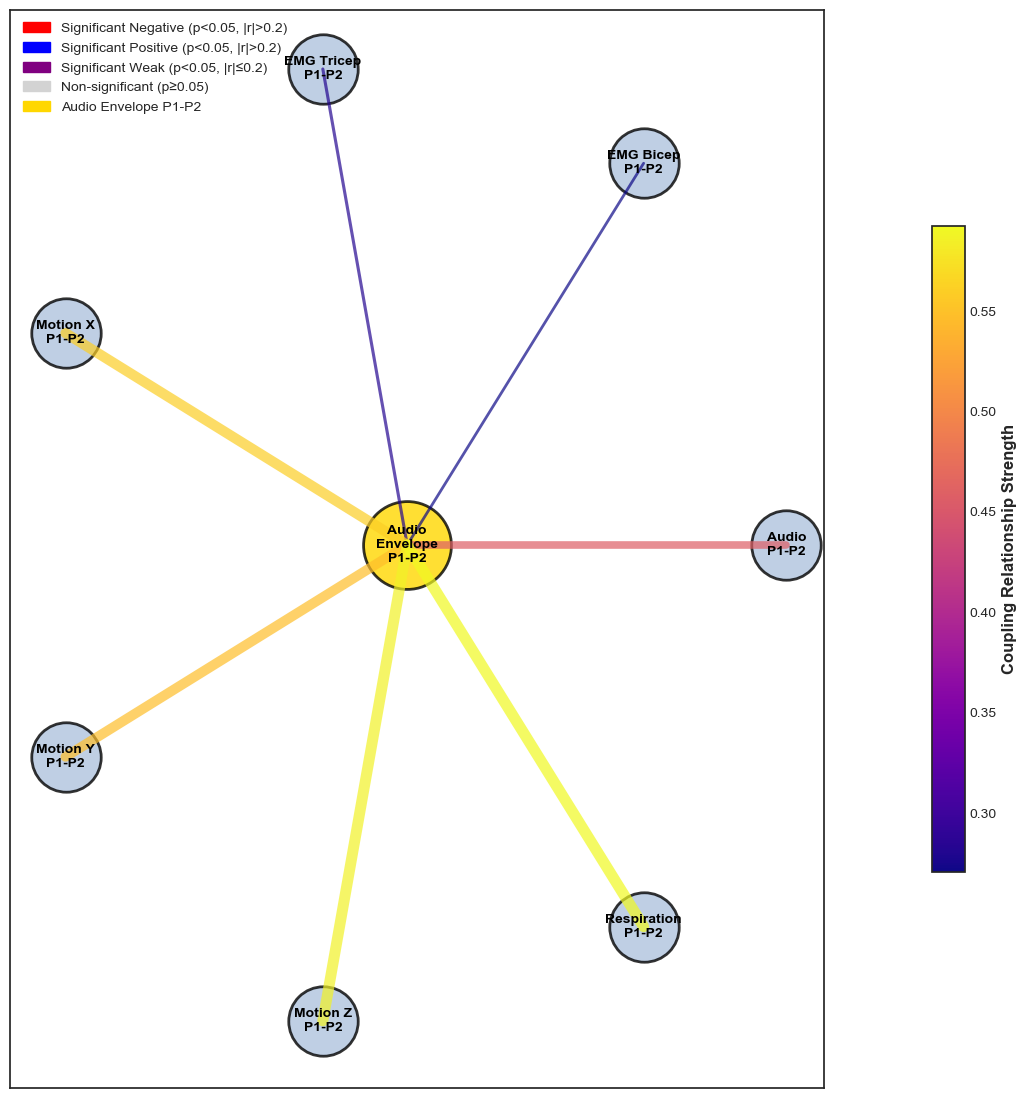

In [ ]:
import matplotlib.pyplot as plt

# Create summary plots if results were generated
output_file = './p1_p2_coupling_statistics.csv'
results_df = pd.read_csv(output_file)
if not results_df.empty:
    #create_plots(results_df, output_folder='coupling_plots/')
    create_complete_coupling_plots(results_df, output_folder='coupling_plots/')
   
    
    # Display some example results
    print("\nExample results:")
    print(results_df.head())
    
    print("\nVariable pair types found:")
    print(results_df['variable_pair_type'].value_counts())